#Project Overview

###Problem Definition

**Objective:** To predict the sales price for each house in the test dataset as accurately as possible. Evaluated based on *Root-Mean-Squared-Error* (RMSE) between the logarithm of the predicted value and actual value (errors for expensive and cheap houses valued equally)

###Relevant Domain Insights
*     Describes residential homes in Ames, Iowa
*    79 explanatory variables per house ranging from the height of the basement ceiling to the proximity to an east-west railroad

#Import Libraries

In [33]:
#Import all relevant libraries 
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from mlxtend.preprocessing import minmax_scaling
from sklearn.feature_selection import mutual_info_regression

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Scaled data')

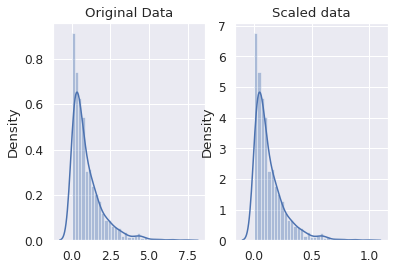

In [34]:
# generate 1000 data points randomly drawn from an exponential distribution
original_data = np.random.exponential(size=1000)

# mix-max scale the data between 0 and 1
scaled_data = minmax_scaling(original_data, columns=[0])

# plot both together to compare
fig, ax = plt.subplots(1,2)
sns.distplot(original_data, ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(scaled_data, ax=ax[1])
ax[1].set_title("Scaled data")

#Acquire Data

In [35]:
#Training and test datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

#Analyze Data (Perform Exploratory Data Analysis)

In [36]:
#Exemplar of first five entries
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


##Heatmap
*    Most noticeable relationship between "Overall Quality" and Sale Price of a house
*    Above grade (ground) living area square footage was another strong predictor
*     Number of bathrooms and garage space were also relatively valuable

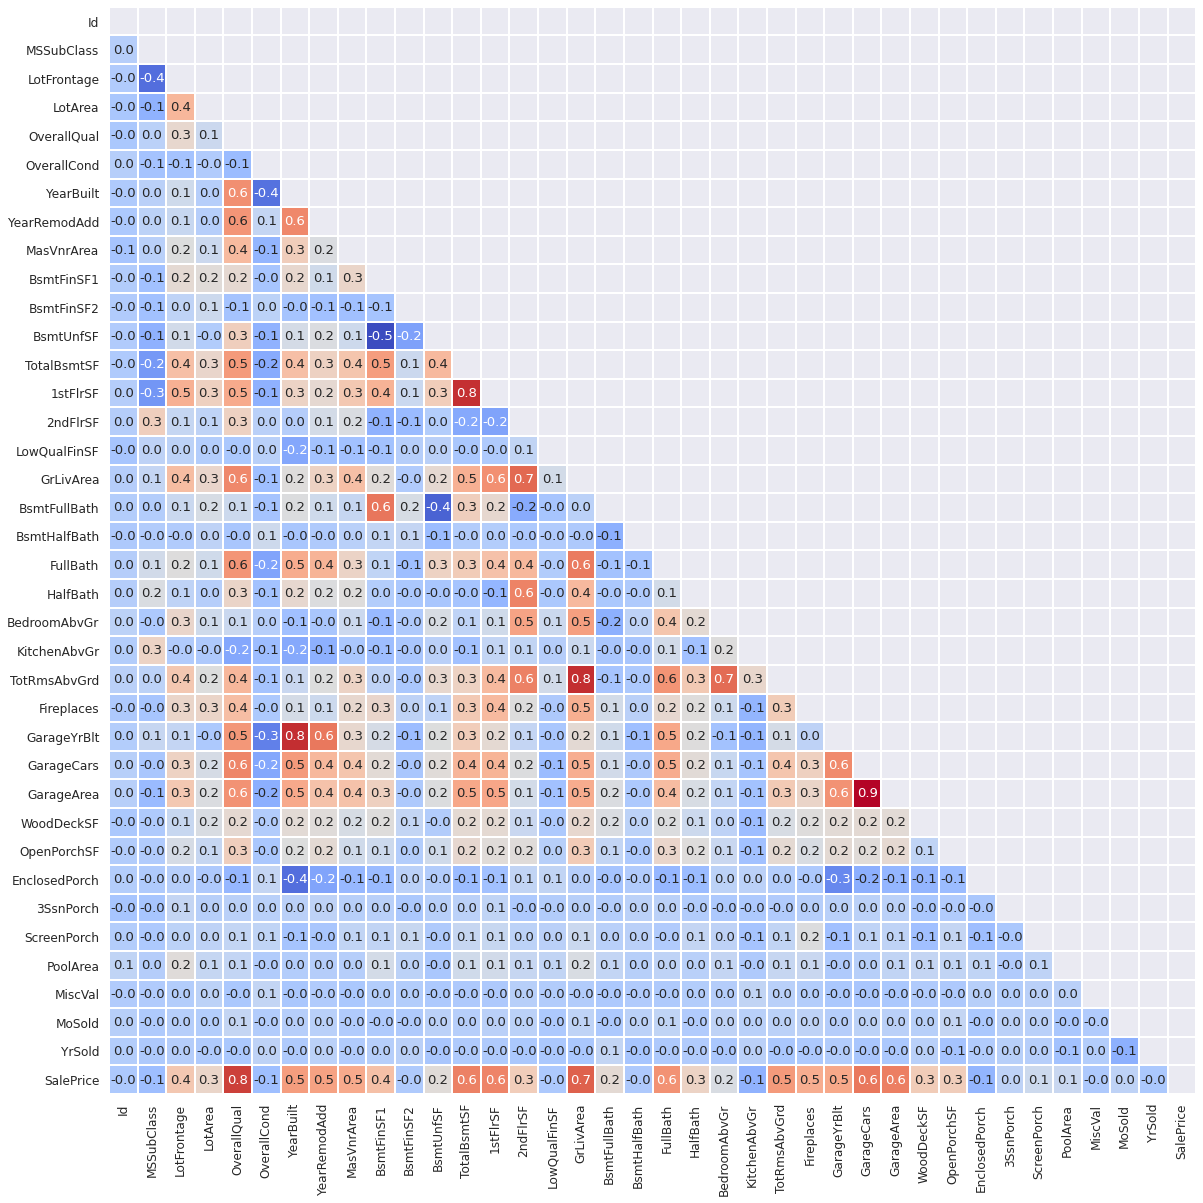

In [37]:
#Heatmap to better understand the correlation between variables
plt.figure(figsize=(20,20))
sns.set(font_scale=1.1)
sns.heatmap(train_df.corr(), 
            cmap='coolwarm', 
            annot=True, 
            fmt='.1f', 
            square=True,  
            cbar=False,
            mask=np.triu(train_df.corr()),
            linewidths=1)

##Categorical Feature Visualization

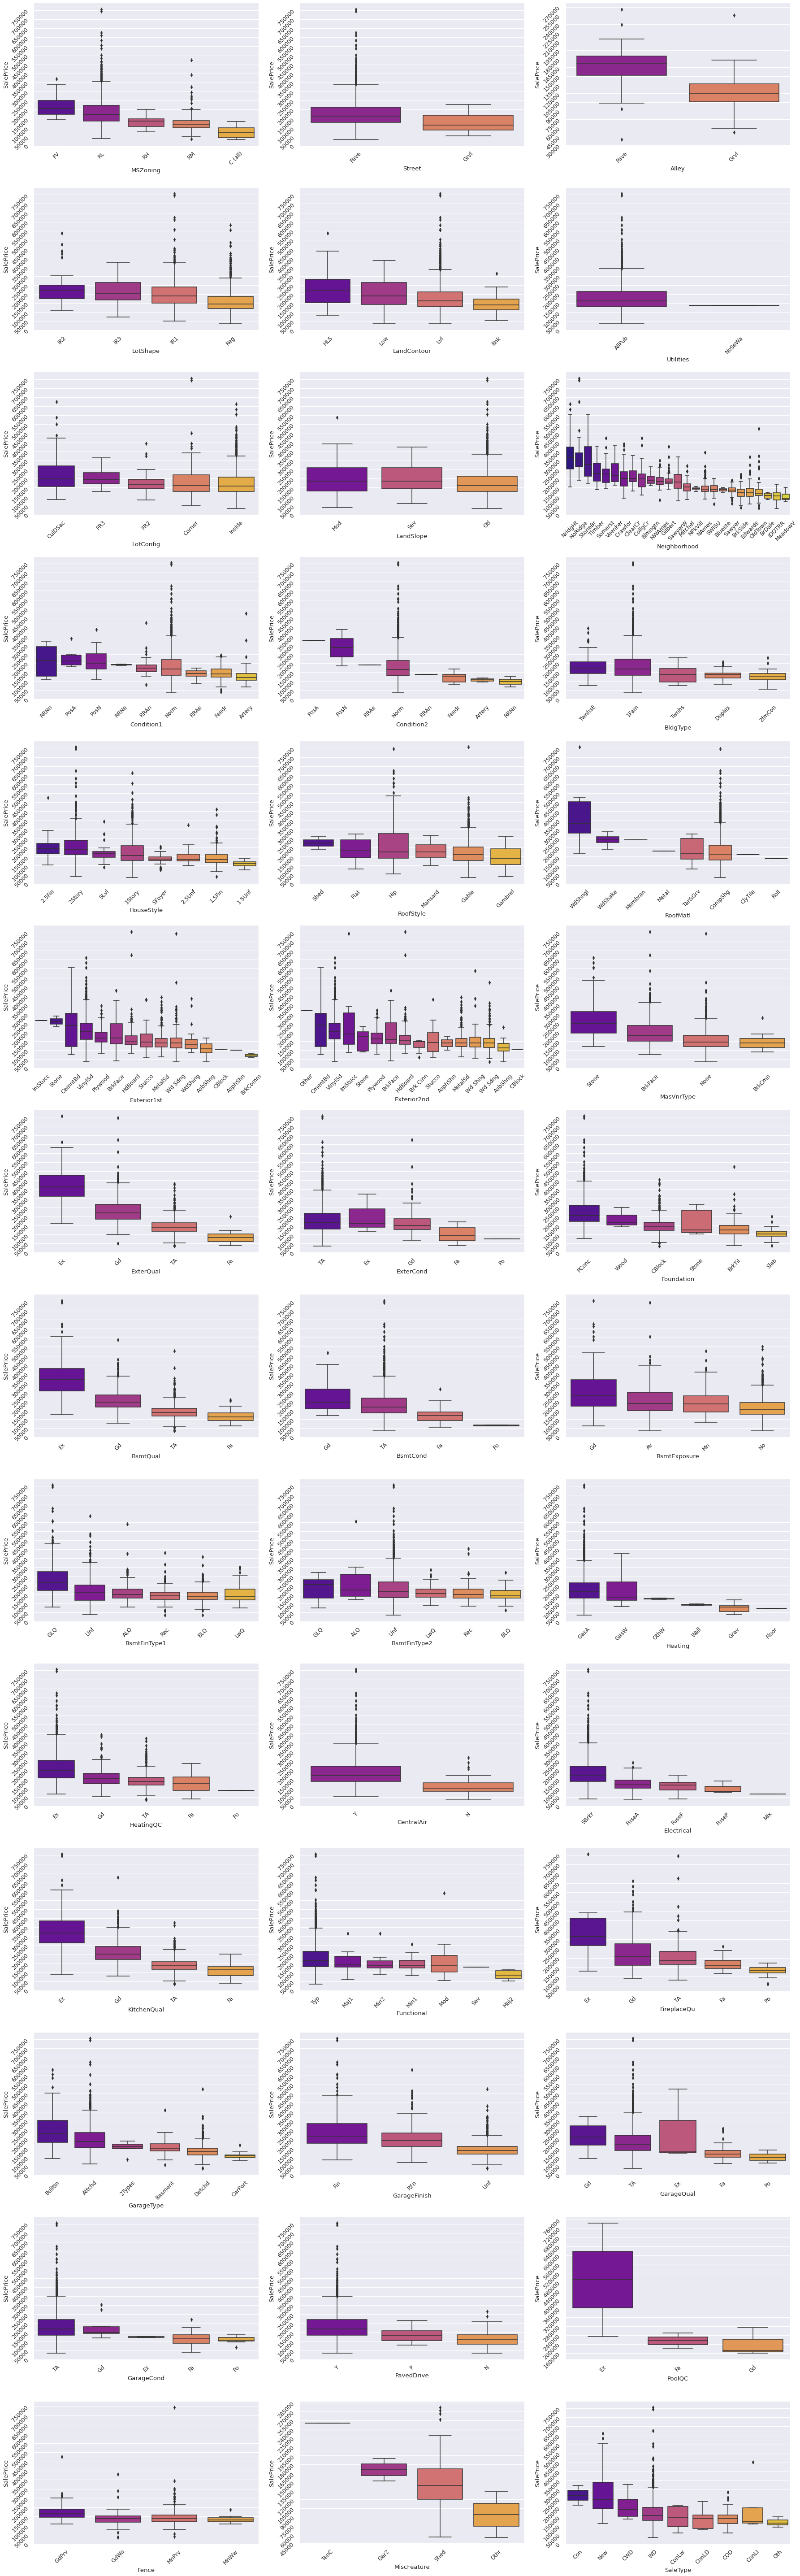

In [38]:
#create empty figures (instance of Figure) and corresponding subplot grid array of Axes
fig, axes = plt.subplots(14, 3, figsize=(25,80))

#flattens the ax from the Axes group to allow for quicker iteration
axes = axes.flatten()

#iterates over both the categorical data columns and the axes (14 of each)
for i,j in zip(train_df.select_dtypes(include=['O']).columns, axes):

  #grouped by different classifications for each categorical class, and determined the median sale price for each class
  sortd = train_df.groupby([i])['SalePrice'].median().sort_values(ascending=False)

  #boxplot where x is the different categories and y is the sale price (train_df is dataset used)
  sns.boxplot(x=i,
              y='SalePrice',
              data=train_df,
              palette='plasma',
              order=sortd.index,
              ax=j)
  
  #rotate 
  j.tick_params(labelrotation=45)

  #maximum 18 ticks on y-axis per plot
  j.yaxis.set_major_locator(MaxNLocator(nbins=18))

  plt.tight_layout()

##Numerical Feature Visualization

/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:256: RankWarning:

Polyfit may be poorly conditioned

/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:256: RankWarning:

Polyfit may be poorly conditioned



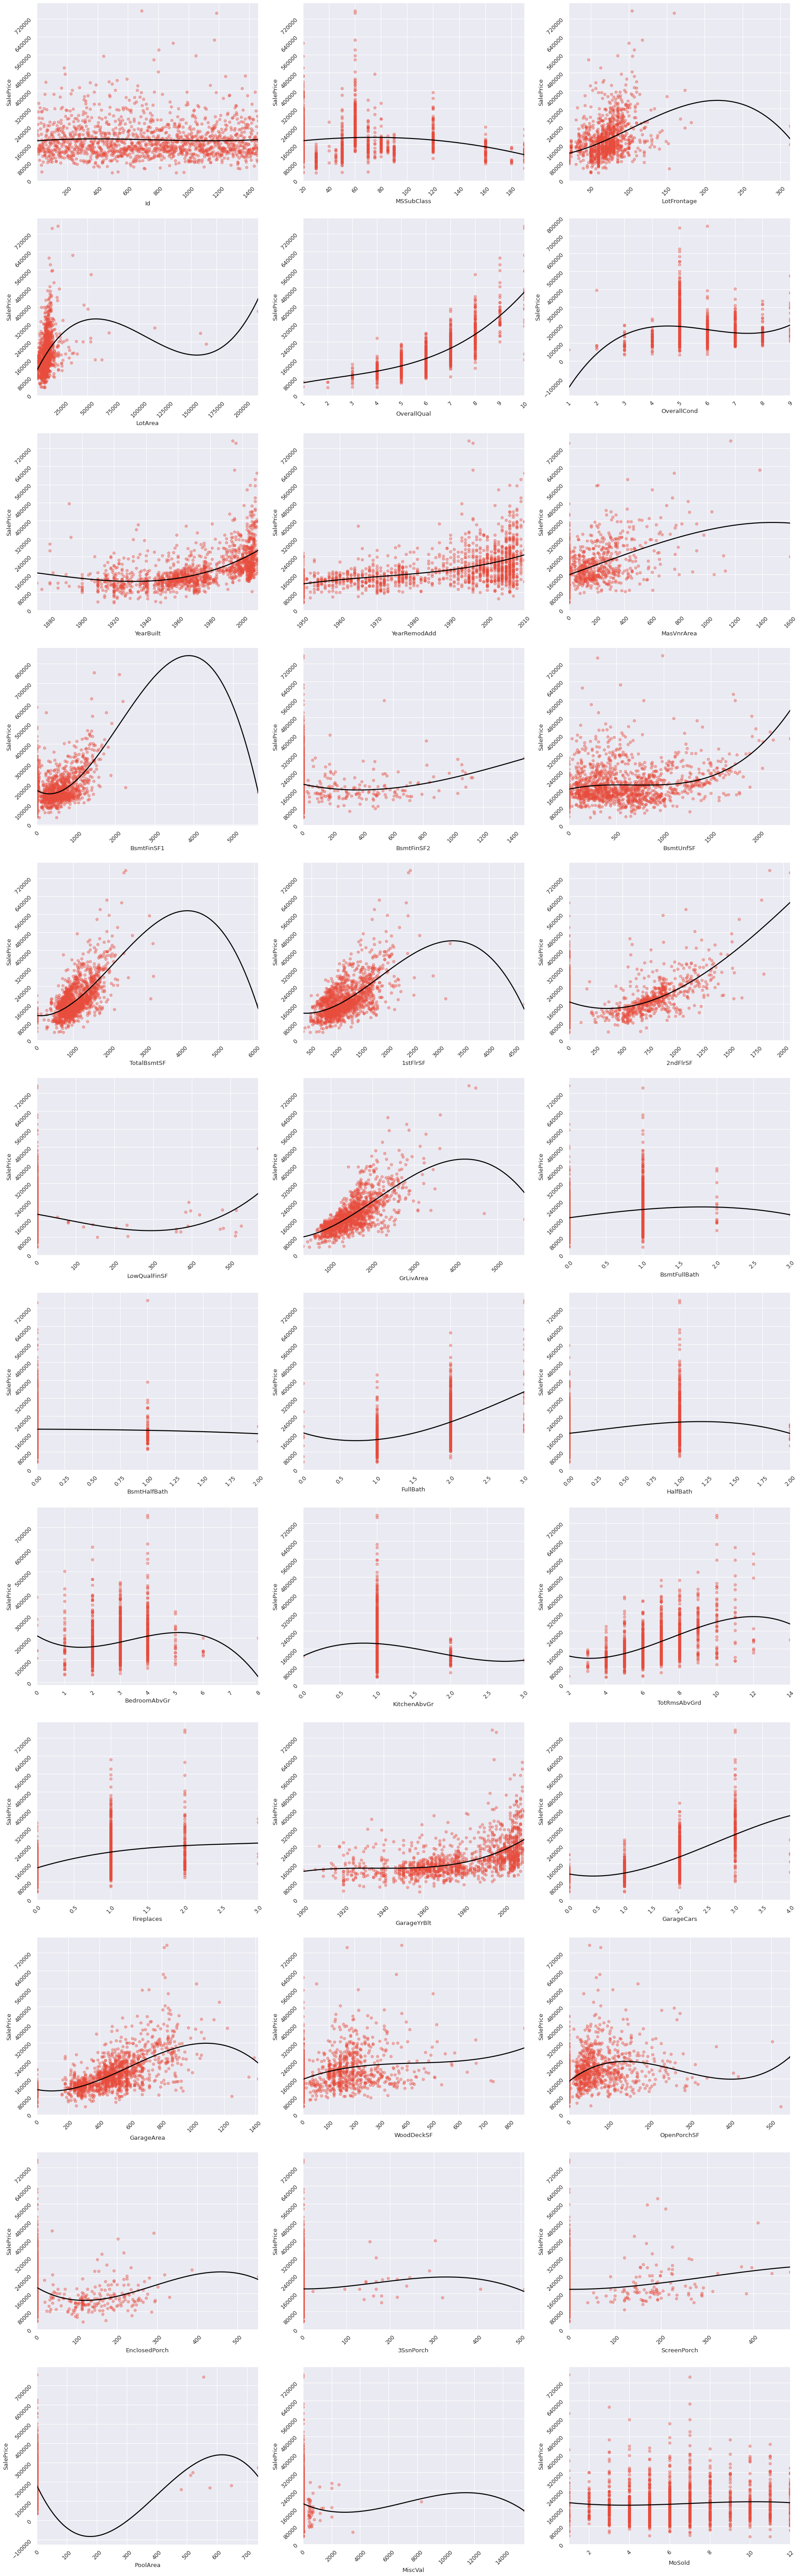

In [39]:
fig, axes = plt.subplots(12, 3, figsize=(25,80))
axes = axes.flatten()

for i, j in zip(train_df.select_dtypes(include=['number']).columns, axes):

  sns.regplot(x=i,
              y='SalePrice',
              data=train_df,
              ax=j,
              order=3,
              ci=None,
              color='#e74c3c',
              line_kws={'color': 'black'},
              scatter_kws={'alpha':0.4})
  
  j.tick_params(labelrotation=45)
  j.yaxis.set_major_locator(MaxNLocator(nbins=10))

  plt.tight_layout()

#Clean Data

##Visualization of missing data

In [40]:
features = pd.concat([train_df.drop(['Id', 'SalePrice'], axis=1), test_df.drop('Id', axis=1)]).reset_index(drop=True)
features.shape

(2919, 79)

In [41]:
#visualization of missing data (excluding entries where there is 0 missing entries for both train and test sets)
total = features.isnull().sum().sort_values(ascending=False)[features.isnull().sum().sort_values(ascending=False) != 0]

percent = round((features.isnull().sum().sort_values(ascending=False) / len(features) * 100)[(features.isnull().sum().sort_values(ascending=False) / len(features) * 100) != 0],2)

missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,LotFrontage,GarageCond,GarageQual,GarageYrBlt,GarageFinish,GarageType,BsmtCond,BsmtExposure,BsmtQual,BsmtFinType2,BsmtFinType1,MasVnrType,MasVnrArea,MSZoning,BsmtHalfBath,Utilities,Functional,BsmtFullBath,BsmtFinSF2,BsmtFinSF1,Exterior2nd,BsmtUnfSF,TotalBsmtSF,Exterior1st,SaleType,Electrical,KitchenQual,GarageArea,GarageCars
Total,2909.000000,2814.000000,2721.000000,2348.000000,1420.000000,486.000000,159.000000,159.000000,159.000000,159.000000,157.000000,82.000000,82.000000,81.000000,80.000000,79.000000,24.000000,23.000000,4.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Percent,99.660000,96.400000,93.220000,80.440000,48.650000,16.650000,5.450000,5.450000,5.450000,5.450000,5.380000,2.810000,2.810000,2.770000,2.740000,2.710000,0.820000,0.790000,0.140000,0.070000,0.070000,0.070000,0.070000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000


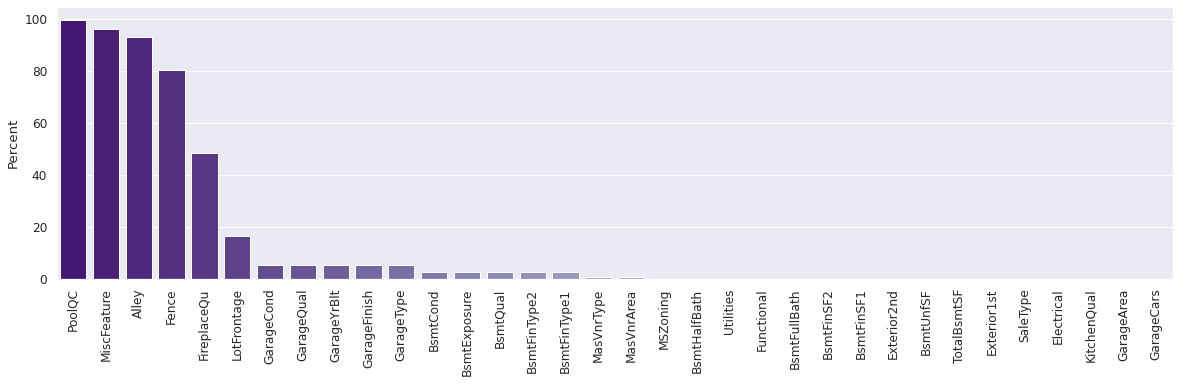

In [42]:
plt.figure(figsize=(20,5))

sns.barplot(x=missing.index, y='Percent', data=missing, palette= 'Purples_r')
plt.xticks(rotation=90)

missing.T.style.background_gradient(cmap='Purples', axis=1)

# PLOTLY EXPRESS ALTERNATIVE
#px.bar(missing,x=missing.index, y='Percent')

##Replace NaN's accordingly for categorical (None) and numerical (0) features

In [43]:
#NaN's categorically (replace with None)
#NaN's numerically (replace with zero)
none_cols = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu', 'MasVnrType']

for col in none_cols:
  train_df[col].replace(np.nan, 'None', inplace=True)
  test_df[col].replace(np.nan, 'None', inplace=True)

zero_cols = ['GarageYrBlt', 'MasVnrArea', 'BsmtHalfBath', 'BsmtFullBath', 'BsmtFinSF2', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GarageCars']

for col in zero_cols:
  train_df[col].replace(np.nan, 0, inplace=True)
  test_df[col].replace(np.nan, 0, inplace=True)



In [44]:
empty_features = []

for i in total.index:
  empty_features.append(i)


remaining = np.setdiff1d(empty_features, zero_cols)
remaining = np.setdiff1d(remaining, none_cols)
remaining

array(['Electrical', 'Exterior1st', 'Exterior2nd', 'Functional',
       'KitchenQual', 'LotFrontage', 'MSZoning', 'SaleType', 'Utilities'],
      dtype='<U12')

In [45]:
missing_cols = ['Electrical', 'Exterior1st', 'Exterior2nd', 'Functional', 'KitchenQual', 'SaleType', 'Utilities']

for col in missing_cols:
  train_df[col].replace(np.nan, train_df[col].mode()[0], inplace=True)
  test_df[col].replace(np.nan, test_df[col].mode()[0], inplace=True)

In [46]:
for i in test_df.groupby('MSSubClass')['MSZoning']:
  print(i)

#.apply( lambda x: x.fillna(x.mode()[0]))

(20, 0        RH
1        RL
6        RL
8        RL
9        RL
       ... 
1443     RL
1444    NaN
1447     RL
1451     RL
1456     RL
Name: MSZoning, Length: 543, dtype: object)
(30, 31           RH
66           RL
71           RM
76           RM
83           RM
         ...   
1411         RL
1426         RM
1428         RM
1429         RM
1431    C (all)
Name: MSZoning, Length: 70, dtype: object)
(40, 994     RL
1094    RL
Name: MSZoning, dtype: object)
(45, 73      RM
619     RL
658     RM
937     RL
998     RM
1007    RM
Name: MSZoning, dtype: object)
(50, 47           RL
54           RL
55           RL
62           RL
67           RL
         ...   
1421         RL
1422         RL
1427         RM
1430         RM
1433    C (all)
Name: MSZoning, Length: 143, dtype: object)
(60, 2       RL
3       RL
5       RL
7       RL
15      RL
        ..
1396    RL
1401    RL
1403    RL
1425    RL
1458    RL
Name: MSZoning, Length: 276, dtype: object)
(70, 77      RM
78      RM
80      RM
92

In [47]:
# Fill in MSZoning according to MSSubClass
#Fills each NaN entry with the mode of that (grouped by MSSubClass)
train_df['MSZoning'] = train_df.groupby('MSSubClass')['MSZoning'].apply( lambda x: x.fillna(x.mode()[0]))
test_df['MSZoning'] = test_df.groupby('MSSubClass')['MSZoning'].apply( lambda x: x.fillna(x.mode()[0]))

#Fill in Lot Frontage using Neighbourhood
#Fills each NaN entry with the mode of that (grouped by Neighbourhood)
train_df['LotFrontage'] = train_df.groupby('Neighborhood')['LotFrontage'].apply( lambda x: x.fillna(x.median()))
test_df['LotFrontage'] = test_df.groupby('Neighborhood')['LotFrontage'].apply( lambda x: x.fillna(x.median()))

In [48]:
#Create a dictionary of features and the corresponding percentage of data that is missing for each
train_data = train_df.isnull().sum()/len(train_df)
train_data_dict = train_data.to_dict()

In [49]:
#Same as above except for the test dataset
test_data = test_df.isnull().sum()/len(test_df)
test_data_dict = test_data.to_dict()

In [50]:
#Getting values that have less than 10% of data missing
train_low, test_low = [], []

for i in train_data_dict.keys():
  if 0 < train_data_dict[i] < 0.1:
    train_low.append(i)

for i in test_data_dict.keys():
  if 0 < test_data_dict[i] < 0.1:
    test_low.append(i)


In [51]:
combine = [train_df, test_df]

In [52]:
train_data = train_df.isnull().sum()/len(train_df)
train_data_dict = train_data.to_dict()

test_data = test_df.isnull().sum()/len(test_df)
test_data_dict = test_data.to_dict()

In [53]:
#Get the amount of missing (null) data per column and then divide by total to get percentage of missing data

train_zeroes = []
for i in train_data_dict.keys():
  if train_data_dict[i] == 0:
    train_zeroes.append(i)

print(train_zeroes)

['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC'

In [54]:
#Get the amount of missing (null) data per column and then divide by total to get percentage of missing data
test_zeroes = []
for i in test_data_dict.keys():
  if test_data_dict[i] == 0:
    test_zeroes.append(i)

print(test_zeroes)

['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC'

In [55]:
intersection = set(train_zeroes).intersection(test_zeroes)
print(len(intersection))

80


In [56]:
#Understand amount of missing entries and data types for each feature
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [57]:
features = train_df.columns

num = 0
feature_dict = {}
for i in features:
  feature_dict[num] = i
  num+=1

###Notable Insights from .describe()

In [58]:
#Distribution of data at 25th, 50th, 75th percentile
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.199658,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1868.739726,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,22.431902,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,453.697295,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1958.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,70.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1977.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000



###Distribution of Categorical Data Features

In [59]:
#Distribution of categorical data (of type 'Object')
train_df.describe(include=['O'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
unique,5,2,3,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,5,5,5,7,7,6,5,2,5,4,7,6,7,4,6,6,3,4,5,5,9,6
top,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,None,Attchd,Unf,TA,TA,Y,None,None,None,WD,Normal
freq,1151,1454,1369,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,872,906,1282,647,649,1311,953,430,1256,1428,741,1365,1335,735,1360,690,870,605,1311,1326,1340,1453,1179,1406,1267,1198


#Wrangle Data
*     Start by dropping features so that we deal with fewer data points (and leave out anything that's not useful)

In [60]:
#Save the sale price (dependent variable / label) in it's own Pandas Series then drop from training set
money = train_df.SalePrice
train_df = train_df.drop(['SalePrice'], axis=1)

In [61]:
#Show shape of dataset (combine into a list for simple iteration when needed)
print("Before: ", train_df.shape, test_df.shape)

#Narrow down training and testing sets to only include data with NO missing entries
train_df = train_df[intersection]
test_df = test_df[intersection]

combine = [train_df, test_df]

print('After: ', train_df.shape, test_df.shape)

Before:  (1460, 80) (1459, 80)
After:  (1460, 80) (1459, 80)


In [62]:
s = (train_df.dtypes == 'object')
object_cols_train = list(s[s].index)
object_cols_train

['Fence',
 'Exterior1st',
 'Street',
 'MiscFeature',
 'RoofStyle',
 'BsmtCond',
 'Functional',
 'GarageQual',
 'HeatingQC',
 'Alley',
 'MSZoning',
 'LandSlope',
 'CentralAir',
 'BsmtFinType1',
 'BsmtExposure',
 'Heating',
 'LotShape',
 'Exterior2nd',
 'Condition1',
 'ExterCond',
 'BsmtQual',
 'PavedDrive',
 'PoolQC',
 'GarageType',
 'Utilities',
 'Condition2',
 'MasVnrType',
 'GarageCond',
 'GarageFinish',
 'HouseStyle',
 'FireplaceQu',
 'Electrical',
 'RoofMatl',
 'LotConfig',
 'ExterQual',
 'SaleCondition',
 'Neighborhood',
 'KitchenQual',
 'BsmtFinType2',
 'Foundation',
 'BldgType',
 'SaleType',
 'LandContour']

In [63]:
#axis = 0 (this is BY DEFAULT) means concatenation takes place vertically rather than horizontally
vertical_stack = pd.concat([train_df, test_df]).reset_index(drop=True)
vertical_stack

,Fence,WoodDeckSF,Exterior1st,1stFlrSF,Street,TotRmsAbvGrd,BsmtFinSF2,MiscFeature,RoofStyle,YrSold,BsmtCond,3SsnPorch,Functional,2ndFlrSF,GarageQual,HeatingQC,Alley,MSZoning,LandSlope,BsmtUnfSF,CentralAir,BsmtFinType1,BsmtExposure,YearBuilt,GarageYrBlt,Heating,EnclosedPorch,LotArea,HalfBath,LotShape,Fireplaces,Exterior2nd,Condition1,BsmtHalfBath,FullBath,ExterCond,MasVnrArea,BsmtQual,BsmtFinSF1,PoolArea,PavedDrive,PoolQC,GarageType,GarageCars,Id,Utilities,MSSubClass,OpenPorchSF,Condition2,MasVnrType,GarageCond,BsmtFullBath,LowQualFinSF,GarageArea,LotFrontage,GarageFinish,BedroomAbvGr,HouseStyle,TotalBsmtSF,FireplaceQu,Electrical,RoofMatl,GrLivArea,LotConfig,KitchenAbvGr,ExterQual,SaleCondition,OverallQual,Neighborhood,KitchenQual,MiscVal,BsmtFinType2,Foundation,ScreenPorch,BldgType,SaleType,MoSold,YearRemodAdd,LandContour,OverallCond
0,None,0,VinylSd,856,Pave,8,0.0,None,Gable,2008,TA,0,Typ,854,TA,Ex,None,RL,Gtl,150.0,Y,GLQ,No,2003,2003.0,GasA,0,8450,1,Reg,0,VinylSd,Norm,0.0,2,TA,196.0,Gd,706.0,0,Y,None,Attchd,2.0,1,AllPub,60,61,Norm,BrkFace,TA,1.0,0,548.0,65.0,RFn,3,2Story,856.0,None,SBrkr,CompShg,1710,Inside,1,Gd,Normal,7,CollgCr,Gd,0,Unf,PConc,0,1Fam,WD,2,2003,Lvl,5
1,None,298,MetalSd,1262,Pave,6,0.0,None,Gable,2007,TA,0,Typ,0,TA,Ex,None,RL,Gtl,284.0,Y,ALQ,Gd,1976,1976.0,GasA,0,9600,0,Reg,1,MetalSd,Feedr,1.0,2,TA,0.0,Gd,978.0,0,Y,None,Attchd,2.0,2,AllPub,20,0,Norm,None,TA,0.0,0,460.0,80.0,RFn,3,1Story,1262.0,TA,SBrkr,CompShg,1262,FR2,1,TA,Normal,6,Veenker,TA,0,Unf,CBlock,0,1Fam,WD,5,1976,Lvl,8
2,None,0,VinylSd,920,Pave,6,0.0,None,Gable,2008,TA,0,Typ,866,TA,Ex,None,RL,Gtl,434.0,Y,GLQ,Mn,2001,2001.0,GasA,0,11250,1,IR1,1,VinylSd,Norm,0.0,2,TA,162.0,Gd,486.0,0,Y,None,Attchd,2.0,3,AllPub,60,42,Norm,BrkFace,TA,1.0,0,608.0,68.0,RFn,3,2Story,920.0,TA,SBrkr,CompShg,1786,Inside,1,Gd,Normal,7,CollgCr,Gd,0,Unf,PConc,0,1Fam,WD,9,2002,Lvl,5
3,None,0,Wd Sdng,961,Pave,7,0.0,None,Gable,2006,Gd,0,Typ,756,TA,Gd,None,RL,Gtl,540.0,Y,ALQ,No,1915,1998.0,GasA,272,9550,0,IR1,1,Wd Shng,Norm,0.0,1,TA,0.0,TA,216.0,0,Y,None,Detchd,3.0,4,AllPub,70,35,Norm,None,TA,1.0,0,642.0,60.0,Unf,3,2Story,756.0,Gd,SBrkr,CompShg,1717,Corner,1,TA,Abnorml,7,Crawfor,Gd,0,Unf,BrkTil,0,1Fam,WD,2,1970,Lvl,5
4,None,192,VinylSd,1145,Pave,9,0.0,None,Gable,2008,TA,0,Typ,1053,TA,Ex,None,RL,Gtl,490.0,Y,GLQ,Av,2000,2000.0,GasA,0,14260,1,IR1,1,VinylSd,Norm,0.0,2,TA,350.0,Gd,655.0,0,Y,None,Attchd,3.0,5,AllPub,60,84,Norm,BrkFace,TA,1.0,0,836.0,84.0,RFn,4,2Story,1145.0,TA,SBrkr,CompShg,2198,FR2,1,Gd,Normal,8,NoRidge,Gd,0,Unf,PConc,0,1Fam,WD,12,2000,Lvl,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,None,0,CemntBd,546,Pave,5,0.0,None,Gable,2006,TA,0,Typ,546,None,Gd,None,RM,Gtl,546.0,Y,Unf,No,1970,0.0,GasA,0,1936,1,Reg,0,CmentBd,Norm,0.0,1,TA,0.0,TA,0.0,0,Y,None,None,0.0,2915,AllPub,160,0,Norm,None,None,0.0,0,0.0,21.0,None,3,2Story,546.0,None,SBrkr,CompShg,1092,Inside,1,TA,Normal,4,MeadowV,TA,0,Unf,CBlock,0,Twnhs,WD,6,1970,Lvl,7
2915,None,0,CemntBd,546,Pave,6,0.0,None,Gable,2006,TA,0,Typ,546,TA,TA,None,RM,Gtl,294.0,Y,Rec,No,1970,1970.0,GasA,0,1894,1,Reg,0,CmentBd,Norm,0.0,1,TA,0.0,TA,252.0,0,Y,None,CarPort,1.0,2916,AllPub,160,24,Norm,None,TA,0.0,0,286.0,21.0,Unf,3,2Story,546.0,None,SBrkr,CompShg,1092,Inside,1,TA,Abnorml,4,MeadowV,TA,0,Unf,CBlock,0,TwnhsE,WD,4,1970,Lvl,5
2916,None,474,VinylSd,1224,Pave,7,0.0,None,Gable,2006,TA,0,Typ,0,TA,Ex,None,RL,Gtl,0.0,Y,ALQ,No,1960,1960.0,GasA,0,20000,0,Reg,1,VinylSd,Norm,0.0,1,TA,0.0,TA,1224.0,0,Y,None,Detchd,2.0,2917,AllPub,20,0,Norm,None,TA,1.0,0,576.0,160.0,Unf,4,1Story,1224.0,TA,SBrkr,CompShg,1224,Inside,1,TA,Abnorml,5,Mitchel,TA,0,Unf,CBlock,0,1Fam,WD,9,1996,Lvl,7
2917,MnPrv,80,HdBoard,970,Pave,6,0.0,Shed,Gable,2006,TA,0,Typ,0,None,TA,None,RL,Gtl,575.0,Y,GLQ,Av,199

In [64]:
#Perform OneHotEncoding on all categorical features to feed into model
from sklearn.preprocessing import OneHotEncoder

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(vertical_stack[object_cols_train]))
OH_cols.index = vertical_stack.index

num_training = vertical_stack.drop(object_cols_train, axis=1)

vertical_stack = pd.concat([num_training, OH_cols], axis=1)

vertical_stack

,WoodDeckSF,1stFlrSF,TotRmsAbvGrd,BsmtFinSF2,YrSold,3SsnPorch,2ndFlrSF,BsmtUnfSF,YearBuilt,GarageYrBlt,EnclosedPorch,LotArea,HalfBath,Fireplaces,BsmtHalfBath,FullBath,MasVnrArea,BsmtFinSF1,PoolArea,GarageCars,Id,MSSubClass,OpenPorchSF,BsmtFullBath,LowQualFinSF,GarageArea,LotFrontage,BedroomAbvGr,TotalBsmtSF,GrLivArea,KitchenAbvGr,OverallQual,MiscVal,ScreenPorch,MoSold,YearRemodAdd,OverallCond,0,1,2,...,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265
0,0,856,8,0.0,2008,0,854,150.0,2003,2003.0,0,8450,1,0,0.0,2,196.0,706.0,0,2.0,1,60,61,1.0,0,548.0,65.0,3,856.0,1710,1,7,0,0,2,2003,5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,298,1262,6,0.0,2007,0,0,284.0,1976,1976.0,0,9600,0,1,1.0,2,0.0,978.0,0,2.0,2,20,0,0.0,0,460.0,80.0,3,1262.0,1262,1,6,0,0,5,1976,8,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0,920,6,0.0,2008,0,866,434.0,2001,2001.0,0,11250,1,1,0.0,2,162.0,486.0,0,2.0,3,60,42,1.0,0,608.0,68.0,3,920.0,1786,1,7,0,0,9,2002,5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0,961,7,0.0,2006,0,756,540.0,1915,1998.0,272,9550,0,1,0.0,1,0.0,216.0,0,3.0,4,70,35,1.0,0,642.0,60.0,3,756.0,1717,1,7,0,0,2,1970,5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,192,1145,9,0.0,2008,0,1053,490.0,2000,2000.0,0,14260,1,1,0.0,2,350.0,655.0,0,3.0,5,60,84,1.0,0,836.0,84.0,4,1145.0,2198,1,8,0,0,12,2000,5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,0,546,5,0.0,2006,0,546,546.0,1970,0.0,0,1936,1,0,0.0,1,0.0,0.0,0,0.0,2915,160,0,0.0,0,0.0,21.0,3,546.0,1092,1,4,0,0,6,1970,7,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2915,0,546,6,0.0,2006,0,546,294.0,1970,1970.0,0,1894,1,0,0.0,1,0.0,252.0,0,1.0,2916,160,24,0.0,0,286.0,21.0,3,546.0,1092,1,4,0,0,4,1970,5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2916,474,1224,7,0.0,2006,0,0,0.0,1960,1960.0,0,20000,0,1,0.0,1,0.0,1224.0,0,2.0,2917,20,0,1.0,0,576.0,160.0,4,1224.0,1224,1,5,0,0,9,1996,7,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2917,80,970,6,0.0,2006,0,0,575.0,1992,0.0,0,10441,0,0,1.0,1,0.0,337.0,0,0.0,2918,85,32,0.0,0,0.0,62.0,3,912.0,970,1,5,700,0,7,1992,5,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [65]:
#Separate back out the training and testing sets having encoded all categorical features

#1460 rows in the training set
train_df, test_df = vertical_stack[:1460], vertical_stack[1460:]
train_df

,WoodDeckSF,1stFlrSF,TotRmsAbvGrd,BsmtFinSF2,YrSold,3SsnPorch,2ndFlrSF,BsmtUnfSF,YearBuilt,GarageYrBlt,EnclosedPorch,LotArea,HalfBath,Fireplaces,BsmtHalfBath,FullBath,MasVnrArea,BsmtFinSF1,PoolArea,GarageCars,Id,MSSubClass,OpenPorchSF,BsmtFullBath,LowQualFinSF,GarageArea,LotFrontage,BedroomAbvGr,TotalBsmtSF,GrLivArea,KitchenAbvGr,OverallQual,MiscVal,ScreenPorch,MoSold,YearRemodAdd,OverallCond,0,1,2,...,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265
0,0,856,8,0.0,2008,0,854,150.0,2003,2003.0,0,8450,1,0,0.0,2,196.0,706.0,0,2.0,1,60,61,1.0,0,548.0,65.0,3,856.0,1710,1,7,0,0,2,2003,5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,298,1262,6,0.0,2007,0,0,284.0,1976,1976.0,0,9600,0,1,1.0,2,0.0,978.0,0,2.0,2,20,0,0.0,0,460.0,80.0,3,1262.0,1262,1,6,0,0,5,1976,8,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0,920,6,0.0,2008,0,866,434.0,2001,2001.0,0,11250,1,1,0.0,2,162.0,486.0,0,2.0,3,60,42,1.0,0,608.0,68.0,3,920.0,1786,1,7,0,0,9,2002,5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0,961,7,0.0,2006,0,756,540.0,1915,1998.0,272,9550,0,1,0.0,1,0.0,216.0,0,3.0,4,70,35,1.0,0,642.0,60.0,3,756.0,1717,1,7,0,0,2,1970,5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,192,1145,9,0.0,2008,0,1053,490.0,2000,2000.0,0,14260,1,1,0.0,2,350.0,655.0,0,3.0,5,60,84,1.0,0,836.0,84.0,4,1145.0,2198,1,8,0,0,12,2000,5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0,953,7,0.0,2007,0,694,953.0,1999,1999.0,0,7917,1,1,0.0,2,0.0,0.0,0,2.0,1456,60,40,0.0,0,460.0,62.0,3,953.0,1647,1,6,0,0,8,2000,5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1456,349,2073,7,163.0,2010,0,0,589.0,1978,1978.0,0,13175,0,2,0.0,2,119.0,790.0,0,2.0,1457,20,0,1.0,0,500.0,85.0,3,1542.0,2073,1,6,0,0,2,1988,6,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1457,0,1188,9,0.0,2010,0,1152,877.0,1941,1941.0,0,9042,0,2,0.0,2,0.0,275.0,0,1.0,1458,70,60,0.0,0,252.0,66.0,4,1152.0,2340,1,7,2500,0,5,2006,9,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1458,366,1078,5,1029.0,2010,0,0,0.0,1950,1950.0,112,9717,0,0,0.0,1,0.0,49.0,0,1.0,1459,20,0,1.0,0,240.0,68.0,2,1078.0,1078,1,5,0,0,4,1996,6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [66]:
test_df

,WoodDeckSF,1stFlrSF,TotRmsAbvGrd,BsmtFinSF2,YrSold,3SsnPorch,2ndFlrSF,BsmtUnfSF,YearBuilt,GarageYrBlt,EnclosedPorch,LotArea,HalfBath,Fireplaces,BsmtHalfBath,FullBath,MasVnrArea,BsmtFinSF1,PoolArea,GarageCars,Id,MSSubClass,OpenPorchSF,BsmtFullBath,LowQualFinSF,GarageArea,LotFrontage,BedroomAbvGr,TotalBsmtSF,GrLivArea,KitchenAbvGr,OverallQual,MiscVal,ScreenPorch,MoSold,YearRemodAdd,OverallCond,0,1,2,...,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265
1460,140,896,5,144.0,2010,0,0,270.0,1961,1961.0,0,11622,0,0,0.0,1,0.0,468.0,0,1.0,1461,20,0,0.0,0,730.0,80.0,2,882.0,896,1,5,0,120,6,1961,6,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1461,393,1329,6,0.0,2010,0,0,406.0,1958,1958.0,0,14267,1,0,0.0,1,108.0,923.0,0,1.0,1462,20,36,0.0,0,312.0,81.0,3,1329.0,1329,1,6,12500,0,6,1958,6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1462,212,928,6,0.0,2010,0,701,137.0,1997,1997.0,0,13830,1,1,0.0,2,0.0,791.0,0,2.0,1463,60,34,0.0,0,482.0,74.0,3,928.0,1629,1,5,0,0,3,1998,5,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1463,360,926,7,0.0,2010,0,678,324.0,1998,1998.0,0,9978,1,1,0.0,2,20.0,602.0,0,2.0,1464,60,36,0.0,0,470.0,78.0,3,926.0,1604,1,6,0,0,6,1998,6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1464,0,1280,5,0.0,2010,0,0,1017.0,1992,1992.0,0,5005,0,0,0.0,2,0.0,263.0,0,2.0,1465,120,82,0.0,0,506.0,43.0,2,1280.0,1280,1,8,0,144,1,1992,5,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,0,546,5,0.0,2006,0,546,546.0,1970,0.0,0,1936,1,0,0.0,1,0.0,0.0,0,0.0,2915,160,0,0.0,0,0.0,21.0,3,546.0,1092,1,4,0,0,6,1970,7,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2915,0,546,6,0.0,2006,0,546,294.0,1970,1970.0,0,1894,1,0,0.0,1,0.0,252.0,0,1.0,2916,160,24,0.0,0,286.0,21.0,3,546.0,1092,1,4,0,0,4,1970,5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2916,474,1224,7,0.0,2006,0,0,0.0,1960,1960.0,0,20000,0,1,0.0,1,0.0,1224.0,0,2.0,2917,20,0,1.0,0,576.0,160.0,4,1224.0,1224,1,5,0,0,9,1996,7,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2917,80,970,6,0.0,2006,0,0,575.0,1992,0.0,0,10441,0,0,1.0,1,0.0,337.0,0,0.0,2918,85,32,0.0,0,0.0,62.0,3,912.0,970,1,5,700,0,7,1992,5,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [67]:
X_train = train_df.drop('Id', axis=1)
Y_train = money
X_test = test_df.drop('Id', axis=1)
X_train.shape, Y_train.shape, X_test.shape

((1460, 302), (1460,), (1459, 302))

X_test

In [68]:
# from sklearn.linear_model import Lasso

# model = Lasso(alpha=1.0)
# model.fit(X_train, Y_train)
# y_pred = model.predict(X_test)

In [69]:
from xgboost import XGBRegressor as xgb
model4 = xgb(n_estimators=1000, learning_rate=0.1)
model4.fit(X_train, Y_train)

y_pred = model4.predict(X_test)

[03:17:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [70]:
test_df['SalePrice'] = y_pred
test_df_final = test_df[['Id', 'SalePrice']] 
test_df_final

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Id,SalePrice
1460,1461,125299.078125
1461,1462,171103.140625
1462,1463,186510.890625
1463,1464,193339.828125
1464,1465,173280.531250
...,...,...
2914,2915,78418.500000
2915,2916,72144.906250
2916,2917,154238.750000
2917,2918,114198.781250


In [ ]:
test_df_final.to_csv('submissionHouse9.csv', index=False)